<a href="https://colab.research.google.com/github/Aidzillafont/Spanish-Wine-/blob/main/Spanish_Wines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Dataset & Goal

We have a number of predictor variables. We will take a look at these visually and we will try to build a model to predict the rating of a bottle of wine.

In [ ]:
import pandas as pd

df = pd.read_csv('https://github.com/Aidzillafont/Spanish-Wine-/blob/875c214bc9f80e5a9859e4c34cdc36914db5ba3c/wines_SPA.csv?raw=true')

print(df.dtypes, df.describe(), df.head(), sep='\n------------------\n')

winery          object
wine            object
year            object
rating         float64
num_reviews      int64
country         object
region          object
price          float64
type            object
body           float64
acidity        float64
dtype: object
------------------
            rating   num_reviews        price         body      acidity
count  7500.000000   7500.000000  7500.000000  6331.000000  6331.000000
mean      4.254933    451.109067    60.095822     4.158427     2.946612
std       0.118029    723.001856   150.356676     0.583352     0.248202
min       4.200000     25.000000     4.990000     2.000000     1.000000
25%       4.200000    389.000000    18.900000     4.000000     3.000000
50%       4.200000    404.000000    28.530000     4.000000     3.000000
75%       4.200000    415.000000    51.350000     5.000000     3.000000
max       4.900000  32624.000000  3119.080000     5.000000     3.000000
------------------
          winery           wine  year  rating  

Lets look at the numerical variables first and how they correlate with each other and rating. Ideally we would like high correlation with rating and low correlation between predictors. If we have high correlation __(|0.9| or more)__ between predictors we would need to investigate and eliminate  some since they possibly explain the same thing or in statistical terms if they are collinear.

Here we can see the year is stored as an object so lets convert that to a int64. There is number of years with 'N.V.' and nan as their value so lets drop them so we can check years correlation

In [ ]:
df_clean = df[df['year']!='N.V.'].dropna()

In [ ]:
df_clean = df_clean.astype({'year':int})

In [ ]:
df_clean.dtypes

winery          object
wine            object
year             int64
rating         float64
num_reviews      int64
country         object
region          object
price          float64
type            object
body           float64
acidity        float64
dtype: object

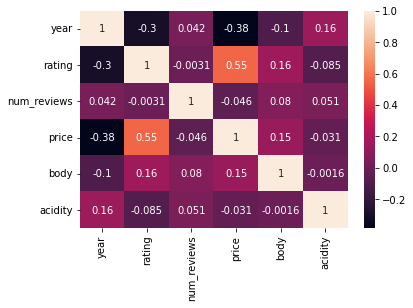

In [ ]:
import seaborn as sns
numeric_cols = list(df_clean.select_dtypes(['float64','int64']).columns)
catag_col = list(df_clean.select_dtypes(['object']).columns)

ax = sns.heatmap(df_clean[numeric_cols].corr(), annot=True)

Okay from the above we can see that none of the variables have a high correlation with rating except for price (0.55). This is unfortunate but it gives us a gauge of how useful these variables may be.

In good news none of the feature variables have a correlation of 0.9 or more with one another.

Now lets explore the categorical variables a little bit see if we can see any patterns. First we will see just how many sub category is in each category.

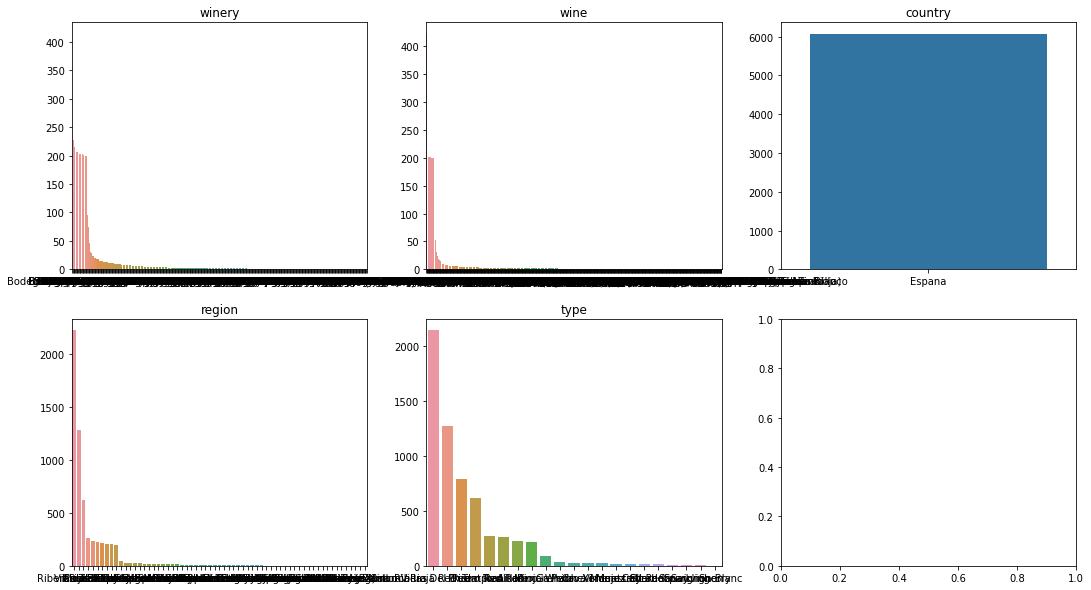

In [ ]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
i=0
j=0
for cat in catag_col:
  counts = df_clean[cat].value_counts()
  sns.barplot(ax=axes[j,i%3], x=counts.index, y=counts.values)
  axes[j,i%3].set_title(cat)
  j= j+1 if i%3==2 else j
  i+=1

From the above we can say a few things:


*   The country variable is the same for all of the data set so it can be removed
*   Of the other catagories we have alot additional levels that do not occur too frequently. This could cause poor performance for our model we may need to tackle this but first lets see how well out model performs.

For categorical variables I will use label encoding since we have too many levels for onehot encoding and we would get a very sparse matrix.

We will check the frequency of catagories. Then we will check out correlation. My working hypothesis here is that more common wines from more common regions will have lower rating. Lets see if it checks out.


In [ ]:
df_clean['region'].value_counts()
cat='region'

for cat in catag_col:
  if cat!='country':
    df_clean['count_{}'.format(cat)] = df_clean.groupby([cat])['country'].transform('count')
  
df_clean.head()

,winery,wine,year,rating,num_reviews,country,region,price,type,body,acidity,count_winery,count_wine,count_region,count_type
0,Teso La Monja,Tinto,2013,4.9,58,Espana,Toro,995.00,Toro Red,5.0,3.0,15,53,264,261
1,Artadi,Vina El Pison,2018,4.9,31,Espana,Vino de Espana,313.50,Tempranillo,4.0,2.0,239,16,238,267
2,Vega Sicilia,Unico,2009,4.8,1793,Espana,Ribera del Duero,324.95,Ribera Del Duero Red,5.0,3.0,95,41,1280,1277
3,Vega Sicilia,Unico,1999,4.8,1705,Espana,Ribera del Duero,692.96,Ribera Del Duero Red,5.0,3.0,95,41,1280,1277
4,Vega Sicilia,Unico,1996,4.8,1309,Espana,Ribera del Duero,778.06,Ribera Del Duero Red,5.0,3.0,95,41,1280,1277


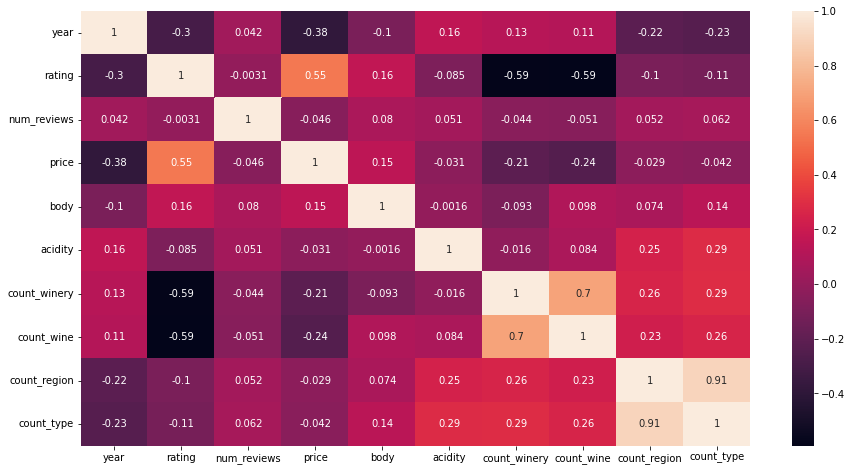

In [ ]:
#reset our numeric columns to get out counts
numeric_cols = list(df_clean.select_dtypes(['float64','int64']).columns)
#a little bigger so its clearer
plt.figure(figsize = (15,8))
ax = sns.heatmap(df_clean[numeric_cols].corr(), annot=True)

We can see from the above that the more common wines from the more common winerys seem to have a lower rating  (-0.59 correlation). 

We see a a strong correlation for the counts of region and type which may indicate that regions and types occur together. However more investigation is required to establish this.

Its worth noteing that the counts of winery and wine have a high correlation with one another. Not greater than 0.9 so we can use them.

Now we will pick some of features based on our above analysis and encode the catagories with labels and stick it into a few models and see how our rating prediction goes.

# Features and Labels

## Features
> year, price, body, wine, winery, region, type
## Label
> rating

In [ ]:
features = ['year', 'price', 'body', 'wine', 'winery', 'region', 'type']
label = ['rating']

Lets quickly check out the distribution of our rating before we start our model

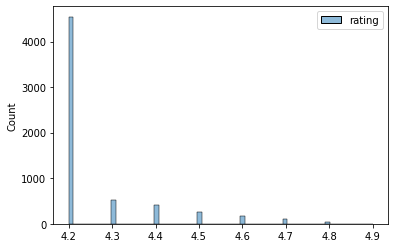

In [ ]:
ax = sns.histplot(df_clean[label])

We dont have alot of different rating values here so I will treat this as a classification problem.

We have a problem of imbalance here. That is our data has the vast majority of cases have a rating of 4.2 so if not considered most models will just predict 4.2 for everything. Hence we need to manage this imbalance. We can do this one of two ways:

1.   Weight our cases by the inverse of the balance
2.   Resample the data set in a balanced way

I will choose weighting our cases.

As for preprocessing we will do the following

1. Transofrm categories to be labeled
2. Scale our numerical values and impute any missing values with median
3. Then fit those into a pipe and call our model



In [ ]:
#models
from sklearn.ensemble import RandomForestClassifier

#preprocess steps
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

#train test splitter and grid search
from sklearn.model_selection import train_test_split, GridSearchCV

#pipline 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

X = df_clean[features]
y = df_clean[label].astype(str) #since we are going to use a classifier

#numeric 
numeric_feat = ['year', 'price', 'body']
numeric_trans = Pipeline([ 
                          ('imputer', SimpleImputer()), 
                          ('scaler', StandardScaler()), 
])

#catagories
cata_feat = ['wine', 'winery', 'region', 'type']
#since our test will likely contain categories not in training 
#we need to tell our ordinal encoder use -1 for unknown values 
cata_trans = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1) 

preprocessor = ColumnTransformer([
                                  ('num', numeric_trans, numeric_feat),
                                  ('cat', cata_trans, cata_feat),
])

#pipleine it all together with a model
pipe = Pipeline([
                  ('preprocess', preprocessor),
                  ('rf', RandomForestClassifier(class_weight='balanced', random_state=69)) #this is our imbalance handler
])

#split our test train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

param_grid = {
    "rf__n_estimators": [100, 300],
    "rf__criterion": ['entropy'],
    "rf__max_depth": [4, 8, 12],
    "rf__max_features": ['auto','sqrt'],
    'rf__max_leaf_nodes': [16,32]
    }

#fit and score the model
cv = GridSearchCV( pipe, param_grid, n_jobs=-1, cv=5, verbose=10)
cv.fit(X_train, y_train.values.ravel())

print('The best score was: ', cv.best_score_, ' with the following parameters.\n')
print(cv.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


The best score was:  0.8161023593681792  with the following parameters.

{'rf__criterion': 'entropy', 'rf__max_depth': 8, 'rf__max_features': 'auto', 'rf__max_leaf_nodes': 32, 'rf__n_estimators': 300}


Great our model scored well but we need to compare this to a benchmark for this I will use a R-0 model where we guess the most common class for everything.

Note: the warning here tells us about one of out classes not having alot of examples meaning our model may not predict this class often if at all. This is why we have passed class_weight='balanced' in our RF

In [ ]:
df_r0 = (y_train.mode().values[0][0] == y_train).value_counts()
df_r0

rating
True      3655
False     1201
dtype: int64

In [ ]:
df_r0[True]/(df_r0[True]+df_r0[False])

0.752677100494234

So guessing the most common class gives us an accuracy of 75% which is below our models performance 81%. Lets check how our model perfoms on test and wrap up our conclusions

In [ ]:
cv.best_estimator_.score(X_test, y_test)

0.7981878088962109

In [ ]:
df_r0 = (y_test.mode().values[0][0] == y_test).value_counts()
df_r0[True]/(df_r0[True]+df_r0[False])

0.7322899505766063

So we see a similar 6% improvement in test over guessing quality of wine. Is this a good improvement? Worth the effort? Well as with all great things statistical it depends......in this case it depends on how much you like your wine.

Thanks for reading my data exploration of bottles of wine. I hope you found it an enjoyable and informative read.